
# Precios del Mercado Diario (Day-Ahead) — Francia (ENTSO-E)

Este cuaderno descarga y procesa los **precios diarios horarios (Day-Ahead)** de Francia a través de la **ENTSO‑E Transparency Platform API**.
Incluye:
- Configuración de parámetros (fechas, token, zona de oferta).
- Llamada a la API y parseo del XML de respuesta.
- Creación de un `DataFrame` con precios horarios en EUR/MWh.
- Gráfico simple de la serie temporal.
- Exportación a CSV.

> **Nota:** Necesitas un **token** válido de ENTSO‑E. Regístrate en la [ENTSO‑E Transparency Platform](https://transparency.entsoe.eu/) y envía un correo a [transparency@entsoe.eu](transparency@entsoe.eu) para despúes poder generar un token en el área de usuario.


In [1]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from datetime import datetime, timedelta, timezone
import xml.etree.ElementTree as ET
from tqdm import tqdm



## Parámetros clave

- `ENTSOE_TOKEN`: tu token personal de la ENTSO‑E.
- `BIDDING_ZONE`: zona de oferta de Francia (RTE).
- `start_date`, `end_date`: rango temporal **en hora local de Francia** (el cuaderno convertirá a UTC para la API).


In [2]:

# RELLENA TU TOKEN EN EL ARCHIVO .ENV ANTES DE EJECUTAR
ENTSOE_TOKEN = os.getenv("ENTSOE_TOKEN")

# Zona de oferta (Bidding Zone) de Francia (RTE)
BIDDING_ZONE = "10YFR-RTE------C"

# Rango temporal
# end_date = datetime.now().date()
# start_date = end_date - timedelta(days=30)

# Para fijar manualmente
start_date = datetime(2020, 1, 1).date()
end_date   = datetime(2024, 12, 31).date()

print("Rango:", start_date, "a", end_date)


Rango: 2020-01-01 a 2024-12-31



## Funciones auxiliares

- Construcción del parámetro `timeInterval` en UTC.
- Descarga y parseo del XML.
- Conversión a `DataFrame`.


In [3]:
def to_utc_interval(start_date, end_date):
    """
    Convierte fechas (YYYY-MM-DD) consideradas en zona Europe/Paris
    a un intervalo UTC con formato ENTSO-E: YYYYMMDDHHMM-YYYYMMDDHHMM.
    
    Incluye desde las 00:00:00 del día start_date hasta las 00:00:00 de end_date + 1 día.
    """

    from zoneinfo import ZoneInfo 

    
    tz_paris = ZoneInfo("Europe/Paris")
    tz_utc = timezone.utc
    
    start_local = datetime.combine(start_date, datetime.min.time()).replace(tzinfo=tz_paris)
    end_local   = datetime.combine(end_date + timedelta(days=1), datetime.min.time()).replace(tzinfo=tz_paris)
    
    start_utc = start_local.astimezone(tz_utc)
    end_utc   = end_local.astimezone(tz_utc)
    
    fmt = "%Y%m%d%H%M"
    return start_utc.strftime(fmt), end_utc.strftime(fmt)


def fetch_day_ahead_prices_fr(token, bidding_zone, start_date, end_date):
    """
    Descarga precios Day-Ahead de ENTSO-E para Francia (zona dada),
    en el rango [start_date, end_date], y devuelve el XML (texto).
    """
    base_url = "https://web-api.tp.entsoe.eu/api"
    start_utc, end_utc = to_utc_interval(start_date, end_date)
    params = {
        "securityToken": token,
        "documentType": "A44",             # Day-ahead prices
        "in_Domain": bidding_zone,
        "out_Domain": bidding_zone,
        "periodStart": start_utc,
        "periodEnd": end_utc
    }
    resp = requests.get(base_url, params=params, timeout=60)
    resp.raise_for_status()
    return resp.text


def parse_prices_xml(xml_text):
    ns = {"ns": "urn:iec62325.351:tc57wg16:451-3:publicationdocument:7:3"}
    tree = ET.ElementTree(ET.fromstring(xml_text))
    
    rows = []
    for period in tree.findall(".//ns:TimeSeries/ns:Period", ns):

        start = pd.to_datetime(period.find("ns:timeInterval/ns:start", ns).text)
        resolution = period.find("ns:resolution", ns).text  # suele ser PT60M o PT120M

        step_hours = int(int(resolution.replace("PT", "").replace("M", "")) / 60)  # p.ej. PT60M -> 1, PT120M -> 2

        # Cada Point tiene una posición (1,2,3...) y un price.amount
        for point in period.findall("ns:Point", ns):
            pos = int(point.find("ns:position", ns).text) - 1  # base 0
            precio = point.find("ns:price.amount", ns).text
            precio = pd.to_numeric(precio, errors="coerce")
            
            # El timestamp inicial de este Point
            ts = start + pd.Timedelta(hours=pos * step_hours)

            # Repetimos el precio tantas horas como diga la resolución
            for h in range(step_hours):
                rows.append({
                    "fecha": ts + pd.Timedelta(hours=h),
                    "precio_Francia": precio
                })

    df = pd.DataFrame(rows)
    df["fecha"] = pd.to_datetime(df["fecha"]).dt.tz_localize(None)
    df = df.sort_values("fecha").reset_index(drop=True)
    
    return df


## Descarga y construcción del DataFrame


In [4]:
try:
    # Dividir el rango en intervalos de máximo 2 meses
    fecha_actual = start_date
    df_list = []

    intervalos = []
    fecha_actual = start_date
    while fecha_actual < end_date:
        siguiente = min(fecha_actual + timedelta(days=60), end_date)
        intervalos.append((fecha_actual, siguiente))
        fecha_actual = siguiente + timedelta(days=1)

    for fecha_inicio, fecha_fin in tqdm(intervalos, desc="Descargando datos de precios de Francia"):
        
        xml_text = fetch_day_ahead_prices_fr(ENTSOE_TOKEN, BIDDING_ZONE, fecha_inicio, fecha_fin)
        xml_text_sin_barra_n = xml_text.replace("\n", "")
        df_tmp = parse_prices_xml(xml_text_sin_barra_n)

        if df_tmp is not None:
            df_list.append(df_tmp)
    
    # Concatenar todos los resultados
    df_prices = pd.concat(df_list, ignore_index=True)
    filas_esperadas = ((end_date - start_date).days + 1) * 24

    print(f"Descargadas {len(df_prices)} filas desde {start_date} a {end_date}. Esperadas {filas_esperadas}. Faltantes {filas_esperadas - len(df_prices)}")
    print(df_prices)

except requests.HTTPError as e:
    print("Error HTTP:", e)
    print("Respuesta:", getattr(e.response, "text", ""))
except Exception as ex:
    print("Error:", ex)


Descargando datos de precios de Francia: 100%|██████████| 30/30 [00:16<00:00,  1.83it/s]

Descargadas 43510 filas desde 2020-01-01 a 2024-12-31. Esperadas 43848. Faltantes 338
                    fecha  precio_Francia
0     2019-12-31 23:00:00           41.88
1     2020-01-01 00:00:00           38.60
2     2020-01-01 01:00:00           36.55
3     2020-01-01 02:00:00           32.32
4     2020-01-01 03:00:00           30.85
...                   ...             ...
43505 2024-12-31 18:00:00           92.78
43506 2024-12-31 19:00:00           79.04
43507 2024-12-31 20:00:00           50.11
43508 2024-12-31 21:00:00           63.36
43509 2024-12-31 22:00:00           60.18

[43510 rows x 2 columns]


## Manejo de valores faltantes

In [5]:
# Como hay menos datos de los esperados, ver qué datos faltan

# Crear rango horario completo entre el mínimo y máximo timestamp
rango_horas = pd.date_range(start_date, end_date, freq='h')

# Reindexar para asegurar que todas las horas estén presentes
df_prices = df_prices.set_index('fecha').reindex(rango_horas).rename_axis('fecha').reset_index()

# Los precios faltantes quedan como NaN
df_prices[df_prices['precio_Francia'].isna()]

,fecha,precio_Francia
8,2020-01-01 08:00:00,NaN
422,2020-01-18 14:00:00,NaN
441,2020-01-19 09:00:00,NaN
903,2020-02-07 15:00:00,NaN
1095,2020-02-15 15:00:00,NaN
...,...,...
42949,2024-11-24 13:00:00,NaN
42950,2024-11-24 14:00:00,NaN
42963,2024-11-25 03:00:00,NaN
43381,2024-12-12 13:00:00,NaN


In [52]:
# Calcular el porcentaje de valores faltantes en la columna 'precio_Francia'
num_faltantes = df_prices['precio_Francia'].isna().sum()
total = len(df_prices)
porcentaje_faltantes = 100 * num_faltantes / total if total > 0 else 0
print(f"Porcentaje de faltantes: {porcentaje_faltantes:.2f}%")

Porcentaje de faltantes: 0.77%


### Visualizaciones de valores faltantes

In [23]:
figsize = (14, 6)

title_fontsize = 16
xlabel_fontsize = 13

ylabel_fontsize = 13
xticks_fontsize = 14
yticks_fontsize = 14

xticks_rotation = 0

title_fontweight = 'bold'
xlabel_fontweight = 'bold'
ylabel_fontweight = 'bold'

legend_fontsize = 15

Ver si los faltantes se suelen acumular en alguna hora del día


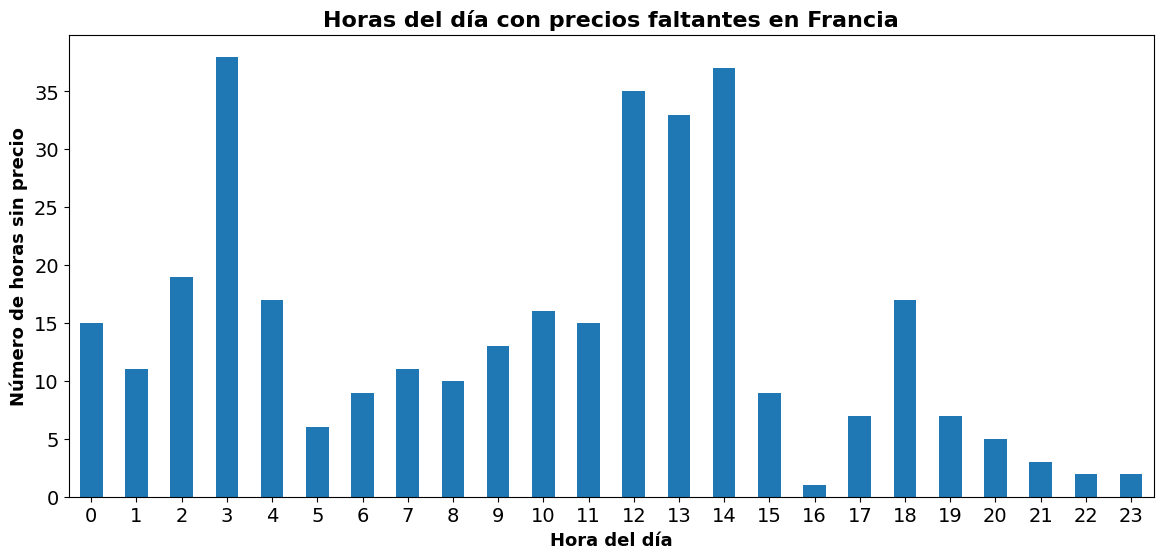

In [ ]:
# Calcular valores faltantes por hora
faltantes_por_hora = df_prices[df_prices['precio_Francia'].isna()]['fecha'].dt.hour.value_counts().sort_index()
total_faltantes = faltantes_por_hora.sum()

ax = faltantes_por_hora.plot(xticks=range(24), kind='bar')

ax.set_title('Horas del día con precios faltantes en Francia', fontsize=title_fontsize, fontweight=title_fontweight)
ax.set_xlabel('Hora del día', fontsize=xlabel_fontsize, fontweight=xlabel_fontweight)
ax.set_ylabel('Número de horas sin precio', fontsize=ylabel_fontsize, fontweight=ylabel_fontweight)
ax.tick_params(axis='x', labelsize=xticks_fontsize, rotation=xticks_rotation)
ax.tick_params(axis='y', labelsize=yticks_fontsize)
plt.gcf().set_size_inches(figsize)

Ver si los nulos se acumulan en algún día del mes

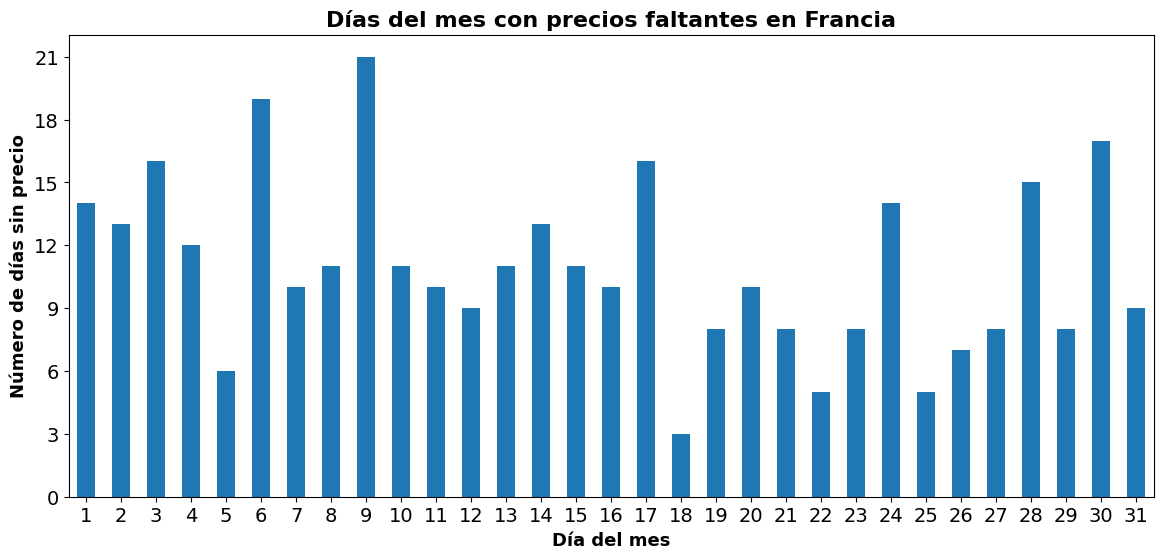

In [ ]:
from matplotlib.ticker import MaxNLocator

# Calcular valores faltantes por dia del mes
faltantes_por_dia = df_prices[df_prices['precio_Francia'].isna()]['fecha'].dt.day.value_counts().sort_index()
total_faltantes = faltantes_por_dia.sum()

ax = faltantes_por_dia.plot(kind='bar')
ax.set_xticks(range(len(faltantes_por_dia)))
ax.set_xticklabels(faltantes_por_dia.index)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('Días del mes con precios faltantes en Francia', fontsize=title_fontsize, fontweight=title_fontweight)
ax.set_xlabel('Día del mes', fontsize=xlabel_fontsize, fontweight=xlabel_fontweight)
ax.set_ylabel('Número de días sin precio', fontsize=ylabel_fontsize, fontweight=ylabel_fontweight)
ax.tick_params(axis='x', labelsize=xticks_fontsize, rotation=xticks_rotation)
ax.tick_params(axis='y', labelsize=yticks_fontsize)
plt.gcf().set_size_inches(figsize)

Ver si los nulos se acumulan algún día de la semana

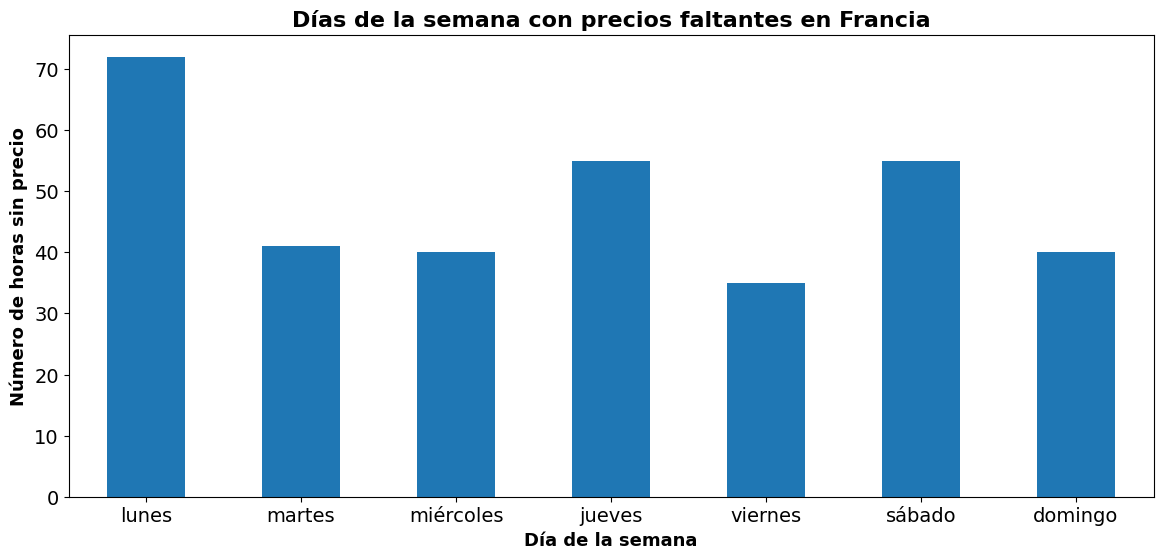

In [39]:
import locale

# Establecer el locale a español para los nombres de los días
locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')

# Obtener los nombres de los días en español
dias_es = df_prices[df_prices['precio_Francia'].isna()]['fecha'].dt.day_name(locale='es_ES')
ax = dias_es.value_counts().sort_index().plot(kind='bar')

ax.set_xlabel('Día de la semana', fontsize=xlabel_fontsize, fontweight=xlabel_fontweight)
ax.set_ylabel('Número de horas sin precio', fontsize=ylabel_fontsize, fontweight=ylabel_fontweight)
ax.set_title('Días de la semana con precios faltantes en Francia', fontsize=title_fontsize, fontweight=title_fontweight)
ax.tick_params(axis='x', labelsize=xticks_fontsize, rotation=xticks_rotation)
ax.tick_params(axis='y', labelsize=yticks_fontsize)

# Ordenar los días de la semana de lunes a domingo
dias_orden = ['lunes', 'martes', 'miércoles', 'jueves', 'viernes', 'sábado', 'domingo']
ax.set_xticks(range(len(dias_orden)))
ax.set_xticklabels(dias_orden)

plt.gcf().set_size_inches(figsize)

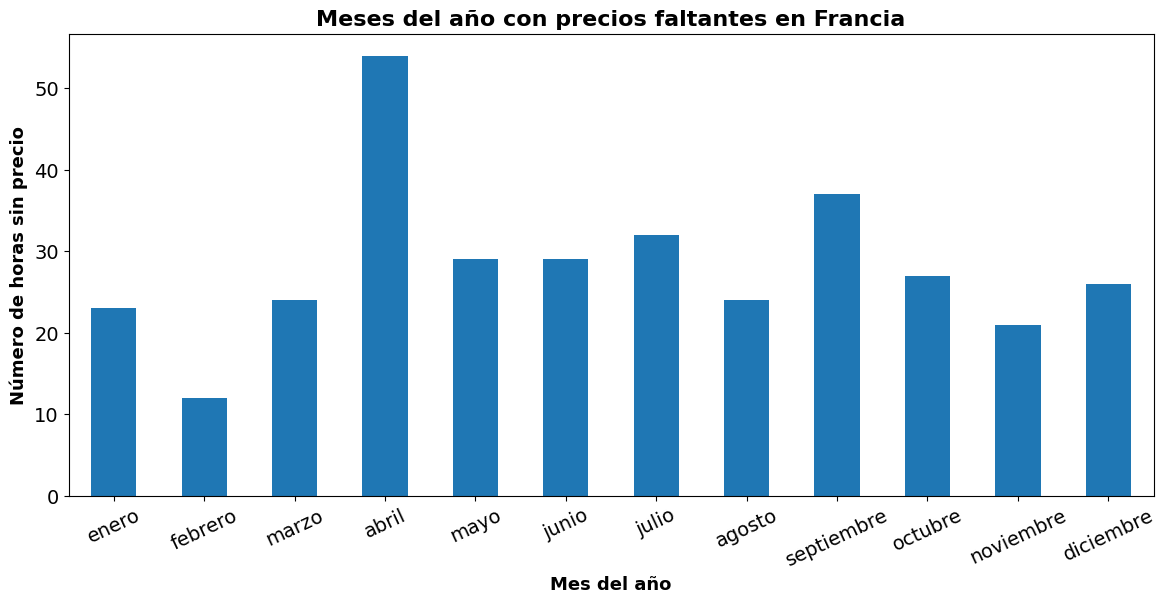

In [42]:
ax = df_prices[df_prices['precio_Francia'].isna()]['fecha'].dt.month.value_counts().sort_index().plot(
    kind='bar'
)
meses_es = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']
ax.set_xticks(range(12))
ax.set_xticklabels(meses_es)

ax.set_xlabel('Mes del año', fontsize=xlabel_fontsize, fontweight=xlabel_fontweight)
ax.set_ylabel('Número de horas sin precio', fontsize=ylabel_fontsize, fontweight=ylabel_fontweight)
ax.set_title('Meses del año con precios faltantes en Francia', fontsize=title_fontsize, fontweight=title_fontweight)
ax.tick_params(axis='x', labelsize=xticks_fontsize, rotation=25)
ax.tick_params(axis='y', labelsize=yticks_fontsize)

plt.gcf().set_size_inches(figsize)

## Rellenado de valores faltantes

In [53]:
# Rellenar valores faltantes con la media de los valores anterior y posterior usando pandas
df_prices['precio_Francia'] = df_prices['precio_Francia'].interpolate(method='linear', limit_direction='both')

# Calcular el numero de valores faltantes en la columna 'precio_Francia'
num_faltantes = df_prices['precio_Francia'].isna().sum()
print(f"Número de valores faltantes: {num_faltantes}")

Número de valores faltantes: 0


## Valores atípicos

In [69]:
# Detectar valores atípicos en la columna 'precio_Francia' usando el método IQR

quantile = 0.01
q1 = df_prices['precio_Francia'].quantile(quantile)
q3 = df_prices['precio_Francia'].quantile(1 - quantile)
iqr = q3 - q1

limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

atipicos = df_prices[(df_prices['precio_Francia'] < limite_inferior) | (df_prices['precio_Francia'] > limite_superior)]

print(f"Número de valores atípicos: {len(atipicos)}")
print("Valores atípicos encontrados:")
print(atipicos[['fecha', 'precio_Francia']])

Número de valores atípicos: 2
Valores atípicos encontrados:
                    fecha  precio_Francia
19781 2022-04-04 05:00:00         2712.99
19782 2022-04-04 06:00:00         2987.78


In [72]:
# Filtrar marzo-abril 2022
mask = (df_prices['fecha'] >= '2022-03-01') & (df_prices['fecha'] < '2022-05-01')
media_marzo_abril_2022 = df_prices.loc[mask, 'precio_Francia'].mean()

print(f"Media de precios de marzo-abril 2022: {media_marzo_abril_2022:.2f} €/MWh")


# Media de precios para las 5 y 6 de la mañana en marzo-abril 2022
media_5am = df_prices.loc[mask & (df_prices['fecha'].dt.hour == 5), 'precio_Francia'].mean()
media_6am = df_prices.loc[mask & (df_prices['fecha'].dt.hour == 6), 'precio_Francia'].mean()

print(f"Media de precios a las 5:00 en marzo-abril 2022: {media_5am:.2f} €/MWh")
print(f"Media de precios a las 6:00 en marzo-abril 2022: {media_6am:.2f} €/MWh")


# Precio del 3/04/2022 a las 5 y a las 6
precio_3_5 = df_prices.loc[df_prices['fecha'] == pd.Timestamp('2022-04-03 05:00'), 'precio_Francia'].values
precio_3_6 = df_prices.loc[df_prices['fecha'] == pd.Timestamp('2022-04-03 06:00'), 'precio_Francia'].values

print(f"Precio 3/04/2022 a las 5:00: {precio_3_5[0]} €/MWh")
print(f"Precio 3/04/2022 a las 6:00: {precio_3_6[0]} €/MWh")

# Precio del 5/04/2022 a las 5 y a las 6
precio_5_5 = df_prices.loc[df_prices['fecha'] == pd.Timestamp('2022-04-05 05:00'), 'precio_Francia'].values
precio_5_6 = df_prices.loc[df_prices['fecha'] == pd.Timestamp('2022-04-05 06:00'), 'precio_Francia'].values

print(f"Precio 5/04/2022 a las 5:00: {precio_5_5[0]} €/MWh")
print(f"Precio 5/04/2022 a las 6:00: {precio_5_6[0]} €/MWh")

Media de precios de marzo-abril 2022: 264.53 €/MWh
Media de precios a las 5:00 en marzo-abril 2022: 325.46 €/MWh
Media de precios a las 6:00 en marzo-abril 2022: 349.24 €/MWh
Precio 3/04/2022 a las 5:00: 275.0 €/MWh
Precio 3/04/2022 a las 6:00: 277.34 €/MWh
Precio 5/04/2022 a las 5:00: 372.27 €/MWh
Precio 5/04/2022 a las 6:00: 448.9 €/MWh


In [96]:
atipicos


,fecha,precio_Francia
19781,2022-04-04 05:00:00,2712.99
19782,2022-04-04 06:00:00,2987.78


In [97]:
for idx, valores in atipicos.iterrows():
    fecha = valores['fecha']

    # Día anterior y siguiente a la misma hora
    fecha_ant = fecha - pd.Timedelta(days=1)
    fecha_sig = fecha + pd.Timedelta(days=1)

    valor_ant = df_prices.loc[df_prices['fecha'] == fecha_ant, 'precio_Francia']
    valor_sig = df_prices.loc[df_prices['fecha'] == fecha_sig, 'precio_Francia']

    # Si ambos existen y no son NaN, interpola
    if not valor_ant.empty and not valor_sig.empty:
        v_ant = valor_ant.values[0]
        v_sig = valor_sig.values[0]
        if pd.notna(v_ant) and pd.notna(v_sig):
            df_prices.at[idx, 'precio_Francia'] = (v_ant + v_sig) / 2

print("Valores atípicos interpolados:")
print(df_prices.loc[atipicos.index, ['fecha', 'precio_Francia']])

Valores atípicos interpolados:
                    fecha  precio_Francia
19781 2022-04-04 05:00:00         323.635
19782 2022-04-04 06:00:00         363.120



## Gráfico de precios (EUR/MWh)


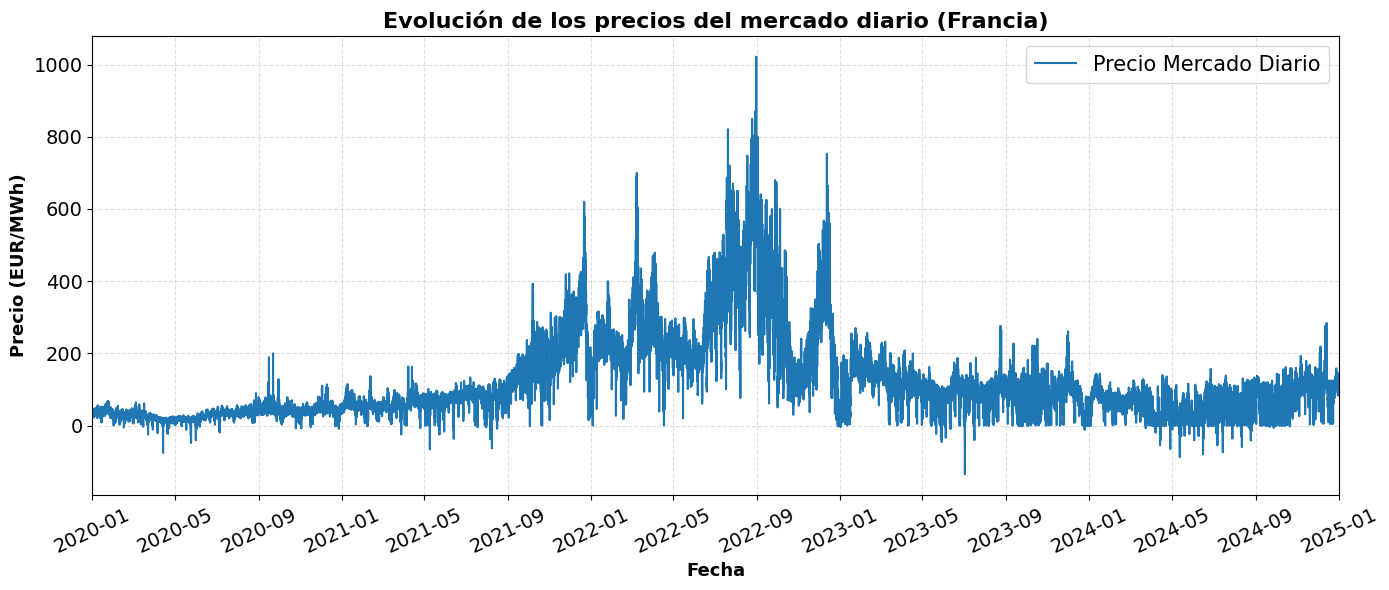

In [98]:

if 'df_prices' in globals() and not df_prices.empty:
    import matplotlib.dates as mdates

    plt.figure(figsize=figsize)
    plt.plot(df_prices["fecha"], df_prices["precio_Francia"])

    plt.title('Evolución de los precios del mercado diario (Francia)', fontsize=title_fontsize, fontweight=title_fontweight)
    plt.xlabel('Fecha', fontsize=xlabel_fontsize, fontweight=xlabel_fontweight)
    plt.ylabel('Precio (€/MWh)', fontsize=ylabel_fontsize, fontweight=ylabel_fontweight)
    plt.grid(True, alpha=0.3)
    plt.legend(['Precio Mercado Diario'], fontsize=legend_fontsize)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 5, 9)))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().set_xlim(df_prices['fecha'].min(), pd.Timestamp('2025-01-01'))
    plt.xticks(rotation=25, fontsize=xticks_fontsize)
    plt.yticks(fontsize=yticks_fontsize)
    plt.ylabel("Precio (EUR/MWh)")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos para graficar. Revisa el token, rango de fechas o la respuesta de la API.")


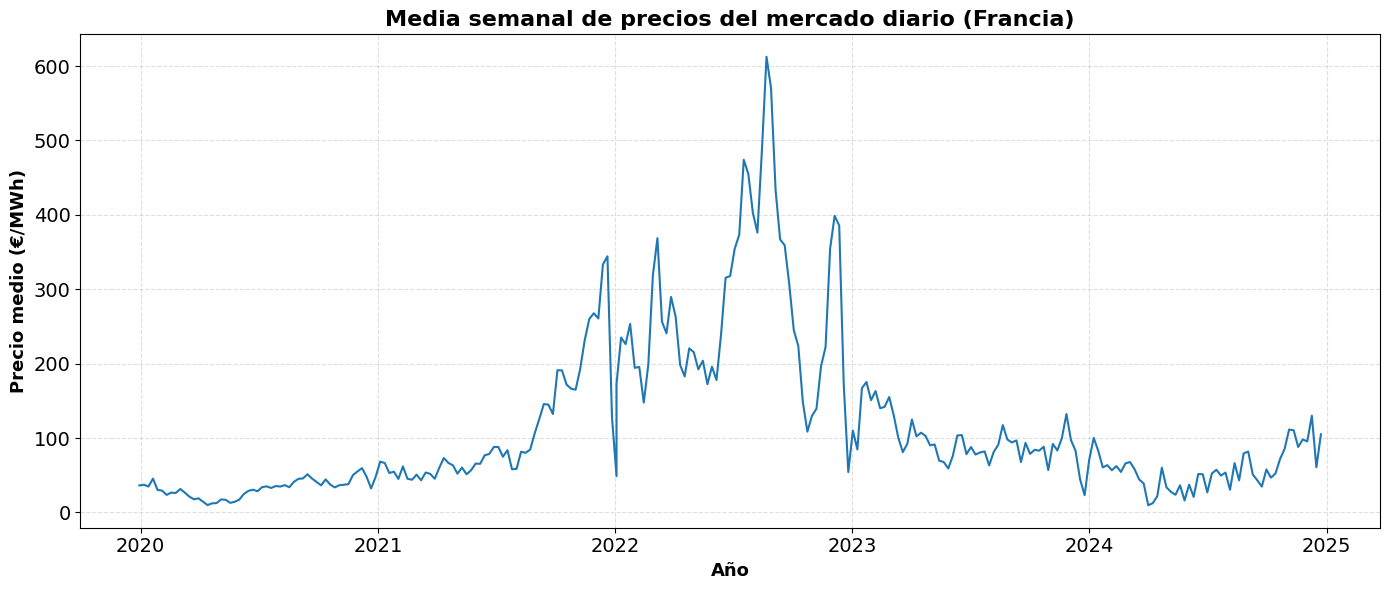

In [101]:
# Calcular la media semanal de precios
df_semanal = df_prices.copy()
df_semanal['semana'] = df_semanal['fecha'].dt.isocalendar().week
df_semanal['año'] = df_semanal['fecha'].dt.year
media_semanal = df_semanal.groupby(['año', 'semana'])['precio_Francia'].mean().reset_index()

# Crear columna de fecha representativa (lunes de cada semana)
media_semanal['fecha'] = pd.to_datetime(media_semanal['año'].astype(str) + '-W' + media_semanal['semana'].astype(str) + '-1', format='%G-W%V-%u')

plt.figure(figsize=(14, 6))
plt.plot(media_semanal['fecha'], media_semanal['precio_Francia'])
plt.title('Media semanal de precios del mercado diario (Francia)', fontsize=16, fontweight='bold')
plt.xlabel('Año', fontsize=13, fontweight='bold')
plt.ylabel('Precio medio (€/MWh)', fontsize=ylabel_fontsize, fontweight=ylabel_fontweight)
plt.xticks(rotation=xticks_rotation, fontsize=xticks_fontsize)
plt.yticks(fontsize=yticks_fontsize)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


## Exportación a CSV

In [103]:

# Ruta de salida (modifica si lo deseas)
csv_path = "../datos/precios_md_Francia.csv"

if 'df_prices' in globals() and not df_prices.empty:
    df_prices.to_csv(csv_path, index=False)
    print("Archivo CSV guardado en:", csv_path)
else:
    print("No se exportó CSV porque no hay datos en df_prices.")

Archivo CSV guardado en: ../datos/precios_md_Francia.csv
